In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from scipy.signal import medfilt

### Preparing Dataset

In [79]:
path = '/wellysis/home/wellysis-tft/Desktop/data/BeatClass/spatch/'

In [12]:
id_list = [i.split('_')[-1].split('.npy')[0] for i in glob(path + 'beatann*.npy')]
id_list2 = [i.split('_')[-1].split('.npy')[0] for i in glob(path +'signal*.npy')]

In [13]:
signal = np.load(path+'signal_' +id_list[0] + '.npy')

In [14]:
beatann = np.load(path+'beatann_' +id_list[0] + '.npy',allow_pickle=True)

In [15]:
beat_idx = beatann[:,0]
beat_ann = beatann[:,1]

In [16]:
def out_baseline_drift(beats, sampling_rate = 256):
        
    window_size = int(sampling_rate) - 1 # Size of the moving window : recommendation 150 < window_size < 256
    ecg_filtered = medfilt(beats, window_size) # must be odd number Ex) 1,3,5,7, ... 

    return beats - ecg_filtered

def processing_sig(beats, max_size=256):

    """
    input : beats, 256 size np.array
    output : processed_sig , 64 size np.array
    """

    input_beat_length = len(beats)
    interpolated_beat_length = int(max_size)
    interpolated_beat = np.interp(
        np.linspace(0, input_beat_length-1, num=interpolated_beat_length),
        np.linspace(0, input_beat_length-1, num=input_beat_length),
        beats
    )

    processed_sig = out_baseline_drift(interpolated_beat) 

    return processed_sig

In [19]:
ecg = np.empty((len(beat_idx),256))

In [20]:
ecg

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
ecg.shape

(234641, 256)

In [22]:
for i,peak in enumerate(beat_idx):
    beat_signal = signal[peak-128:peak+128]
    padding_start = (256 - len(beat_signal)) // 2
    padding_end = 256 - len(beat_signal) - padding_start
    padded_ecg = np.pad(beat_signal, (padding_start, padding_end), 'constant')
    ecg[i,:] = padded_ecg

In [26]:
ecgs = np.array(list(map(processing_sig,ecg)))

### Model Network

In [136]:
def sampling(args):
    """Reparameterization trick. Instead of sampling from Q(z|X), 
    sample eps = N(0,I) z = z_mean + sqrt(var)*eps.

    Parameters:
    -----------
    args: list of Tensors
        Mean and log of variance of Q(z|X)

    Returns
    -------
    z: Tensor
        Sampled latent vector
    """

    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

In [132]:
hidden_dim = 64
latent_dim = 2  # The bigger this is, more accurate the network is but 2 is for illustration purposes.

In [140]:
num_features = 256

### Encoder

In [141]:
inputs = tf.keras.Input(shape=(num_features, ), name='input')
x = tf.keras.layers.Dense(hidden_dim, activation='elu')(inputs)
z_mean = tf.keras.layers.Dense(latent_dim, name = 'z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name = 'z_log_var')(x)

### Sampling Layer

In [138]:
z = tf.keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
# instantiate encoder model
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256)]                0         []                            
                                                                                                  
 dense_25 (Dense)            (None, 64)                   16448     ['input[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 2)                    130       ['dense_25[0][0]']            
                                                                                                  
 z_log_var (Dense)           (None, 2)                    130       ['dense_25[0][0]']            
                                                                                            

### Decoder

In [158]:
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(hidden_dim, activation='elu')(latent_inputs)
outputs = tf.keras.layers.Dense(num_features, activation='elu')(x)

# instantiate decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_30 (Dense)            (None, 64)                192       
                                                                 
 dense_31 (Dense)            (None, 256)               16640     
                                                                 
Total params: 16832 (65.75 KB)
Trainable params: 16832 (65.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [159]:
# # VAE model = encoder + decoder
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = tf.keras.Model(inputs, outputs, name='vae')

In [160]:
# Reconstruction loss
reconstruction_loss = tf.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  16708     ['input[0][0]']               
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 256)                  16832     ['encoder[2][2]']             
                                                                                                

In [161]:
X_train = ecgs[:1000]

In [162]:
X_test = ecgs[1000:2000]

In [163]:
batch_size = 128
epochs = 500

In [168]:
vae.fit(x=X_train , batch_size=batch_size, shuffle=False, epochs=epochs, validation_data = (X_test, None))

Epoch 1/500
8/8 [==============================] - 0s 15ms/step - loss: 1.9404 - val_loss: 3.3084
Epoch 2/500
8/8 [==============================] - 0s 11ms/step - loss: 1.9440 - val_loss: 3.3438
Epoch 3/500
8/8 [==============================] - 0s 12ms/step - loss: 1.9437 - val_loss: 3.2936
Epoch 4/500
8/8 [==============================] - 0s 11ms/step - loss: 1.9535 - val_loss: 3.3590
Epoch 5/500
8/8 [==============================] - 0s 11ms/step - loss: 1.9377 - val_loss: 3.3057
Epoch 6/500
8/8 [==============================] - 0s 12ms/step - loss: 1.9398 - val_loss: 3.3440
Epoch 7/500
8/8 [==============================] - 0s 11ms/step - loss: 1.9347 - val_loss: 3.2922
Epoch 8/500
8/8 [==============================] - 0s 12ms/step - loss: 1.9331 - val_loss: 3.3611
Epoch 9/500
8/8 [==============================] - 0s 12ms/step - loss: 1.9280 - val_loss: 3.2933
Epoch 10/500
8/8 [==============================] - 0s 17ms/step - loss: 1.9325 - val_loss: 3.3443
Epoch 11/500
8/8 [=

In [169]:
pred = vae.predict(X_train)

32/32 [==============================] - 0s 3ms/step


In [182]:
last_hidden_layer_output = vae.layers[3].output

In [183]:
last_hidden_layer_output[1]

<KerasTensor: shape=(64,) dtype=float32 (created by layer 'tf.__operators__.getitem_11')>

In [185]:
last_hidden_layer = tf.keras.backend.function([vae.input], [last_hidden_layer_output])

In [186]:
# 모델 예측 및 출력 얻기
output = last_hidden_layer(X_train)

# numpy array로 출력 얻기
output_np = output[0]

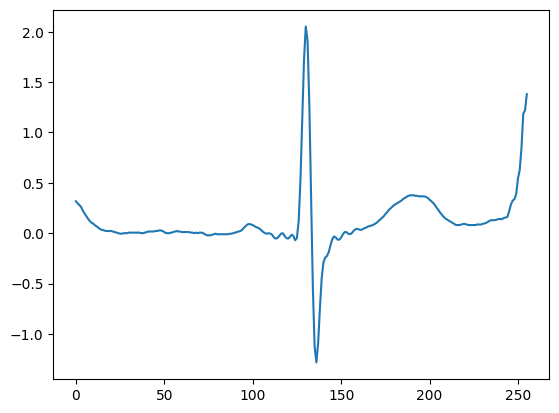

In [193]:
plt.plot(X_train[8])
plt.show()

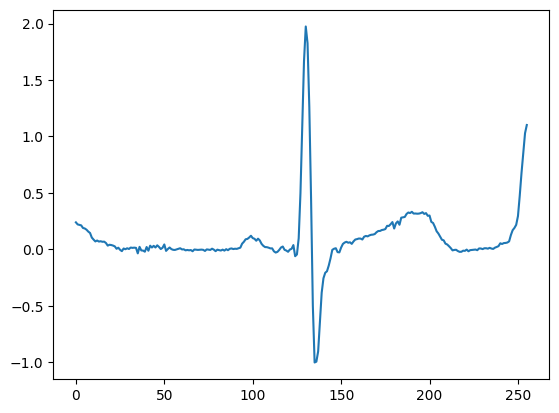

In [192]:
plt.plot(pred[8])
plt.show()

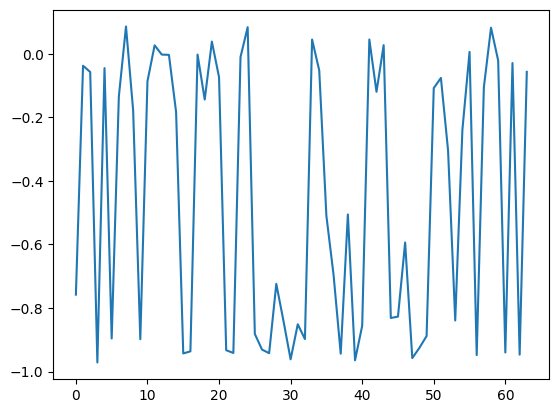

In [188]:
plt.plot(output_np[3])

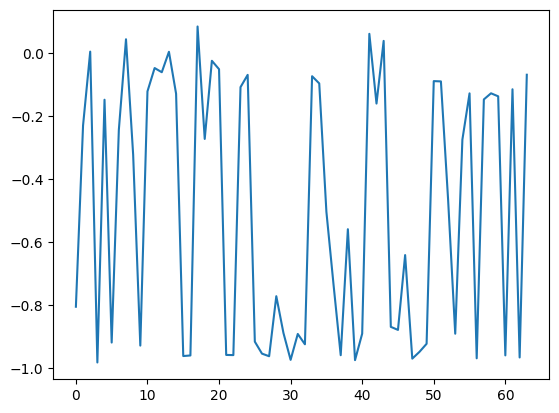

In [191]:
plt.plot(output_np[8])